# The Solow Model

This model project analyzes the Solow model with technological growth and extends it to contain a share of the population at work. The model as then analyzed for different levels of population growth to scrutinize how it affects the steady state levels of output and capital. Finally, this model project combines the extended model and the different levels for population growth to assess the overall affect for the steady state level of capital (and subsequently also for output, however, this is not show formally).

Imports:

In [87]:
import numpy as np
from scipy import optimize
import sympy as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 12})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model Framework

This model project considers the **standard Solow-model** for analyzing long-term economic growth towards a steady state and the dynamics hereof. The model can be formally summarized as follows:

* $K_t$ is capital
* $L_t$ is labor (growing with a constant rate of $n$ - know as a population growth rate)
* $A_t$ is technology (growing with a constant rate of $g$)
* $Y_t = F(K_t,A_tL_t)$ is the production function, which can be interpreted as GDP

**Saving** is a constant fraction of GDP

$$ S_t = sY_t,\,s\in(0,1) $$

such that **capital accumulates** according to

$$ K_{t+1}=S_{t}+(1-\delta)K_{t}=sF(K_{t},A_{t}L_{t})+(1-\delta)K_{t}, \delta \in (0,1) $$

The **production function** has **constant-return to scale** such that

$$ \frac{Y_{t}}{A_{t}L_{t}}=\frac{F(K_{t},A_{t}L_{t})}{A_{t}L_{t}}=F(\tilde{k}_{t},1)\equiv f(\tilde{k}_{t}) $$

where $\tilde{k}_t = \frac{K_t}{A_{t}L_{t}}$ is the technology adjusted capital-labor ratio.

The **transition equation** then becomes

$$ \tilde{k}_{t+1}= \frac{1}{(1+n)(1+g)}[sf(\tilde{k}_{t})+(1-\delta)\tilde{k}_{t}] $$

We assume the **production function** is **Cobb-Douglas** so

$$ F(K_{t},A_{t}L_{t})=K_{t}^{\alpha}(A_{t}L_{t})^{1-\alpha}\Rightarrow f(\tilde{k}_{t})=\tilde{k}_{t}^{\alpha} $$

# Steady state

## Solving the model analytically

We can use **sympy** to find an analytical expression for the steady state, i.e. solve

$$ \tilde{k}^{\ast}= \frac{1}{(1+n)(1+g)}[sf(\tilde{k}^{\ast})+(1-\delta)\tilde{k}^{\ast}] $$

We begin by setting the stage and formalizing all the aforementioned parts of the model framework:

In [88]:
k = sm.symbols('k')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')
s = sm.symbols('s')
g = sm.symbols('g')
n = sm.symbols('n')

Now, we can define the **steady state equation** as the the parameters are now formalized:

In [89]:
steadystate = sm.Eq(k,(s*k**alpha+(1-delta)*k)/((1+n)*(1+g)))

Lasty, we can solve the model analytically as stated above:

In [90]:
k_steadystate= sm.solve(steadystate,k)[0]
k_steadystate

((delta + g*n + g + n)/s)**(1/(alpha - 1))

This function can we save and embed as a function in Python that we will be able to call for later use:

In [91]:
ss_func = sm.lambdify((s,g,n,alpha,delta),k_steadystate)

## Finding the numerical solution

Python comes in handy when we wish to solve the model numerically. We basically do the same as if we were differentiating the function - namely finding the roots. However, to do this we simply reformulate the function such that capital accumulation is equal to zero (steady state):

\\[ 0 = \frac{1}{(1+n)(1+g)}[sf(\tilde{k}^{\ast})+(1-\delta)\tilde{k}^{\ast}] - \tilde{k}^{\ast} \\]

This means that we can solve the model with the **bisection method**.

We need to further augment the model such that the **parameters** have pre-defined values:

In [92]:
s = 0.25
g = 0.03
n = 0.15
alpha = 1/2
delta = 0.05

Hence, the numerical solution for the steady state yields:

In [93]:
def ss_numerical_solution(s,g,n,alpha,delta):
    f = lambda k: k**alpha
    obj_kss = lambda kss: kss - (s*f(kss) + (1-delta)*kss)/((1+g)*(1+n))
    result = optimize.root_scalar(obj_kss,bracket=[0.1,100],method='bisect')
    
    return result

solution = ss_numerical_solution(s,g,n,alpha,delta)

print(f'analytical solution is: {ss_func(s,g,n,alpha,delta):.3f}')
print(f' numerical solution is: {solution.root:.3f}')

analytical solution is: 1.137
 numerical solution is: 1.137


## How will a change in population growth affect output in the economy?

In [94]:
print(f'steady state solution with n=0.15: {ss_func(s,g,0.15,alpha,delta):.3f}')
print(f'steadt state solution with n=0.3: {ss_func(s,g,0.3,alpha,delta):.3f}')

steady state solution with n=0.15: 1.137
steadt state solution with n=0.3: 0.413


As expected the higher population growth decreases the steady state level of capital by means of a decreasing marginal product of labor. The relationship between the steady state and population growth can be illustrated as below:

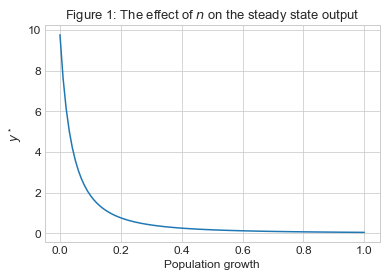

In [95]:
yss_plot = [] #We create a list for the steady state outputs - tom liste skal fyldes ud med ss værdier
n_plot = np.linspace(0,1,100)
for n in n_plot: 
    y=ss_func(s,g,n,alpha,delta)
    yss_plot.append(y) #For each n, find its corresponding ss value and add it to the list for hvert n, så gå ind find ss værdi og smid ind i tom liste
    
#Now we plot the relationship
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Population growth")
ax.set_ylabel("$y^\star$")

ax.set_title('Figure 1: The effect of $n$ on the steady state output', fontsize=13)
ax.plot(n_plot,yss_plot)
plt.show;

Now, we can clearly see that there is a negative relationship netween population growth an steady state output just as anticipated. 

## Illustrating the transition of different population growths

To gain more profound knowlegde of the affect population growth has on steady state, we can simulate its transition using the different growth rates. Both solutions are simulated from period 0 until it reaches steady state.

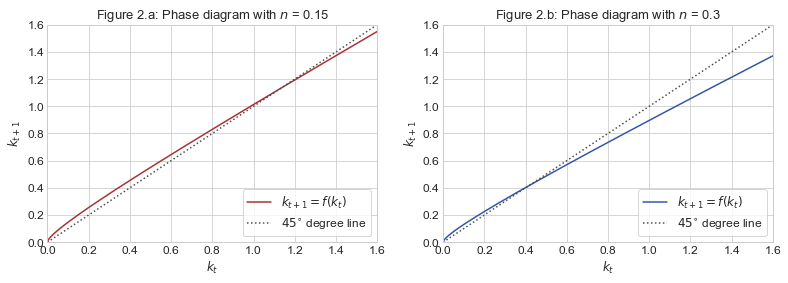

In [96]:
#Transition function of capital as given in the introduction
def k_phase(s,g,n,alpha,delta,k): 
    return (s*k**alpha+(1-delta)*k)/((1+n)*(1+g))

#recalling steady state for capital
def k_ss(delta,g,n,s,alpha):
    return ((delta+g*n+g+n)/s)**(1/(alpha-1))

#Setting the parameters again but with different values for n
s = 0.25
g = 0.03
n1 = 0.15
n2 = 0.3
alpha = 1/2
delta = 0.05

#Period indexing
T = 50
index = range(T)

# Amount of observations or simulated values
N = 1000

# Capital in period t
k_t_1 = np.linspace(0,1.6,N)
k_t_2 = np.linspace(0,1.6,N)

# Capital in period t+1
k_trans_1 = np.zeros(N)
k_trans_2 = np.zeros(N)

for i,k in enumerate(k_t_1):
    k_trans_1[i] = k_phase(s,g,n1,alpha,delta,k)

for i,k in enumerate(k_t_2):
    k_trans_2[i] = k_phase(s,g,n2,alpha,delta,k)
    
fig, axes = plt.subplots(1, 2, sharex='col', figsize=(13, 4))
ax1 = axes[0]
ax2 = axes[1]

#Phase diagram 1:

ax1.plot(k_t_1,k_trans_1, color='#a83232',label=r'$k_{t+1} = f(k_t)$')
ax1.plot(k_t_1,k_t_1,color='0.3',linestyle=':', label=r'$45^{\circ}$ degree line')

ax1.set_ylabel('$k_{t+1}$')
ax1.set_xlabel('$k_t$')
ax1.set_xlim(0,1.6)
ax1.set_ylim(0,1.6)
ax1.legend(loc=4,frameon=True)

ax1.set_title('Figure 2.a: Phase diagram with $n$ = 0.15', fontsize=13)

#Phase diagram 2:

ax2.plot(k_t_2,k_trans_2, color='#3257a8',label=r'$k_{t+1} = f(k_t)$')
ax2.plot(k_t_2,k_t_2,color='0.3',linestyle=':', label=r'$45^{\circ}$ degree line')

ax2.set_ylabel('$k_{t+1}$')
ax2.set_xlabel('$k_t$')
ax2.set_xlim(0,1.6)
ax2.set_ylim(0,1.6)
ax2.legend(loc=4,frameon=True)

ax2.set_title('Figure 2.b: Phase diagram with $n$ = 0.3', fontsize=13)

plt.show()

From comparing the phase diagrams, it becomes clear that an increase in population growth wont only shift the steady state level downwards, it will also decrease the transition towards a stady state as indicated by the slighly steaper slope. 

## Capital convergence towards steady state for different levels of population growth

To further scrutinize the convergence towards steady state, we can illustrate it by means of capital accumulation over time for different levels of population growth.

In [97]:
#Starting point
k0 = 0.00000000000000001

#Period indexing
T = 500
index = range(T)

k_1 = np.zeros(len(index))
k_1[0] = k0

k_phase(s,g,n,alpha,delta,k_t_1[t-1])

for t in index[1:]:
    k_1[t] = k_phase(s,g,n1,alpha,delta,k_t_1[t-1])

k_2 = np.zeros(len(index))
k_2[0] = k0

for t in index[1:]:
    k_2[t] = k_phase(s,g,n2,alpha,delta,k_t_2[t-1])

fig, ax = plt.subplots(sharex='col', figsize=(6.5, 4))
ax.plot(k_1, color='#a83232',label=r'n = 0.15')
ax.plot(k_2,color='#3257a8',linestyle=':', label=r'n = 0.3')
ax.set_ylabel('$k_{t}$')
ax.set_xlabel('t')
ax.legend(loc=4,frameon=True)

ax.set_title('Figure 3: Convergence of capital to steady state', fontsize=13)

plt.show()

NameError: name 't' is not defined

From the figure it becomes clear capital accumulates faster for a lower population growth as opposed to the higher population growth, which implies a shift downwards for the steady state. 

## Extending the Solow model with labor supply

This leads to the following **extended solow model**:

**Production function per capita**:

$$ \tilde{y}_{t}=\frac{Y_{t}}{A_{t}N_{t}}=\lambda^{(1-\alpha)} \tilde{k}_{t}^{\alpha} $$

Implying the following transistion function for **capital accumulation**:

$$ \tilde{k}_{t+1}= \frac{1}{(1+n)(1+g)}[s \lambda^{(1-\alpha)}\tilde{k}_{t}^{\alpha}+(1-\delta)\tilde{k}_{t}] $$



## Analytical solution

We can solve the model analytically just like with the previous model:

In [98]:
k = sm.symbols('k')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')
lamda = sm.symbols('lamda')
s = sm.symbols('s')
g = sm.symbols('g')
n = sm.symbols('n')

steadystate_k_tilde = sm.Eq(k,(s*lamda**(1-alpha)*k**(alpha)+(1-delta)*k)/((1+n)*(1+g)))

In [99]:
k_ss = sm.solve(steadystate_k_tilde,k)[0]
k_ss

(lamda**(1 - alpha)*s/(delta + g*n + g + n))**(-1/(alpha - 1))

## Numerical Solution

In [100]:
#Defining the new parameters
s = 0.25
g = 0.03
n1 = 0.15
n2 = 0.3
n=0.2
alpha = 1/2
delta = 0.05
lamda = 0.02

In [101]:
   # a. define objective function
def solve_for_kss_ext(lamda,s,g,n,alpha,delta):
    func = lambda k: k**alpha
    k_tilde_func = lambda k_tilde: k_tilde - (s*lamda**(1-alpha)*func(k_tilde)+(1-delta)*k_tilde)/((1+n)*(1+g))
    # b. call root finder
    solve = optimize.root_scalar(k_tilde_func,bracket=[0.1,100],method='bisect')
    return solve

    # c. Formulate solution for different population growth rates and print them
solution1 = solve_for_kss_ext(n1,s,g,lamda,alpha,delta)
solution2 = solve_for_kss_ext(n2,s,g,lamda,alpha,delta)

print(f'The numerical solution with n = 0.15 is : {solution1.root:.3f}')
print(f'The numerical solution with n = 0.3 is : {solution2.root:.3f}')

The numerical solution with n = 0.15 is : 0.926
The numerical solution with n = 0.3 is : 1.853


The affect of a change in the population growth rate is now smaller as we defined lambda, which is the share of population supplying labor.

## ## How will a change in population growth affect capital accumulation in the economy after the extension?

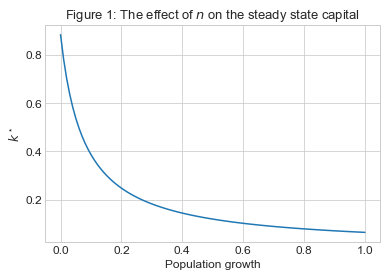

In [102]:
n_plot = np.linspace(0,1,100)
kss_plot = (lamda**(1-alpha)*s/(delta+g*n_plot+g+n_plot))**1/(1-alpha)

#Now we plot the relationship
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Population growth")
ax.set_ylabel("$k^\star$")

ax.set_title('Figure 1: The effect of $n$ on the steady state capital', fontsize=13)
ax.plot(n_plot,kss_plot)
plt.show;

The trend is the same as the standard model before it was extended with the share of the population supplying labor. However, it seems as if the population growth has a smaller effect on the steady state levels after it was augmented. We can combine the population growth with lamdba to make this more clear:

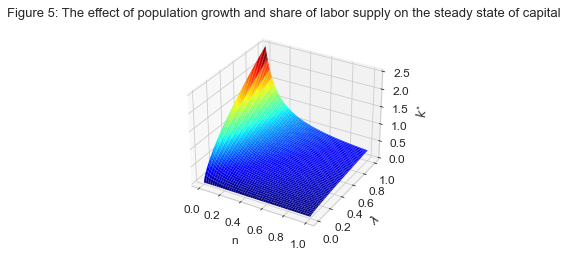

In [103]:
def k_ss_ext_plot(lamda,n,alpha=1/3,delta=0.1,g=0.02,s=0.2):
    k_ss = (lamda**(1-alpha)*s/(delta+g*n+g+n))**1/(1-alpha)
    return k_ss

n_plot = np.linspace(0,1,100)
lamda_plot = np.linspace(0,1,100)
x1_values_alt,x2_values_alt = np.meshgrid(lamda_plot,n_plot,indexing='ij')
u_values_alt = k_ss_ext_plot(x1_values_alt,x2_values_alt,alpha=1/3,delta=0.1,g=0.02,s=0.2)

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot_surface(x2_values_alt,x1_values_alt,u_values_alt,cmap=cm.jet)
ax.set_xlabel("n")
ax.set_ylabel("$\lambda$")
ax.set_zlabel("$k^{\star}$")

ax.set_title('Figure 5: The effect of population growth and share of labor supply on the steady state of capital', fontsize=13);

# Conclusion

This model project analyzed a standard Solow model with technological growth and extended with the share of the population supplying labor. The model project found that as population growth increases, the steady state level of capital, and therefore also output, decreases when population grows at a faster rate. As the model is augmented with the share of population at work, the affect of an increase in population growth as somewhat alleviated, as it now has less impact on the steady state levels of capital and output. 